In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def generate_mesh(L, N, V=0):
    nodes = np.zeros(((N)**2,2))
    tris = np.array([])
    h = L/(N-1)
    coord = np.linspace(0, L, N)
    #Choose variant and generate nodal coordinates
    if V==0:
        for i in range(N):
            nodes[N*i:N*(i+1), 0] = coord
            nodes[N*i:N*(i+1), 1] = coord[i]
    elif V==1:
        for i in range(N):        
            nodes[N*i:N*(i+1), 0] = np.linspace(0, L-i*h/2, N)
            nodes[N*i:N*(i+1), 1] = coord[i]
    elif V==2:
        for i in range(N):        
            nodes[N*i:N*(i+1), 1] = coord[i]
            nodes[N*i:N*(i+1), 0] = coord*(coord*coord[i]/(2*L**2)-coord[i]/(2*L)+1)
    elif V==3:
        angle = np.linspace(0, np.pi/4, N)
        radius = np.linspace(2*L, L, N)
        for i in range(N):        
            nodes[N*i:N*(i+1), 0] = 2*L-radius*np.cos(angle[i])
            nodes[N*i:N*(i+1), 1] = radius*np.sin(angle[i])
    
    #Generate odered triangular elements
    for j in range(N*(N-1)):
        if j%N == 0:
            t = np.array([j, j+1, j+N])
            tris = np.append(tris, t)
        elif j%(N) == N-1:
            t = np.array([j, j+N, j+N-1])
            tris = np.append(tris, t)
        else:
            t = np.array([j, j+N, j+N-1])
            tris = np.append(tris, t)
            t = np.array([j, j+1, j+N])
            tris = np.append(tris, t)
    tris = tris.reshape(int(tris.shape[0]/3), 3)
    tris = tris.astype(int)
    return nodes, tris

coords, elems = generate_mesh(0.02, 10, 0)


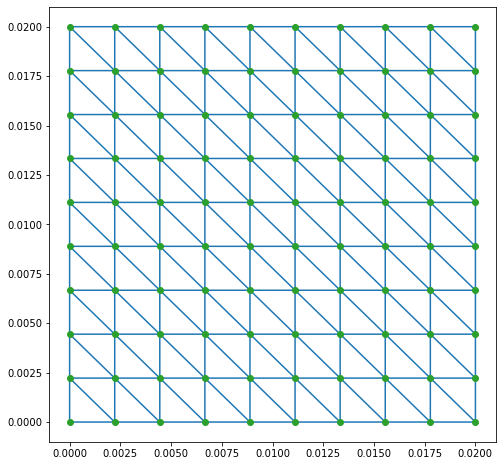

In [5]:
plt.figure(figsize = (8,8))
plt.triplot(coords[:,0], coords[:,1], elems)
plt.plot(coords[:,0], coords[:,1], 'o')
plt.show()

In [16]:
#Global matrix

def assemble_global(nodes, elems, k, hz):
    N = nodes.shape[0]
    H = np.zeros((N,N))
    ref = np.array([[2,-1,-1],[-1,1,0],[-1,0,1]])
    for i in range(elems.shape[0]):
        a = nodes[elems[i, 0]]
        b = nodes[elems[i, 1]]
        c = nodes[elems[i, 2]]
        H_loc = k*hz/2*((b[0]-a[0])*(c[1]-a[1])-(c[0]-a[0])*(b[1]-a[1]))*ref
        for k in range(3):
            for j in range(3):
                H[elems[i, k],elems[i, j]] = H_loc[k,j]
    return H
H1 = assemble_global(coords, elems, 314, 0.001)
print(H1.shape)

(100, 100)


In [25]:
# Implement the BC at the bottom ==============================================================

def calc_BC_bottom(numbNodes):
    # Length in x- and y-direction.
    L = 0.02
    # Thickness (z-direction).
    hz = 0.001
    q_nbc = 1500000.
    numb_nodes_vertically = 10
    numb_elements = numb_nodes_vertically - 1

    # assumption is that the length is in meter
    # The heat on one element
    Q = q_nbc * (L*hz)/numb_elements

    P_nodes = []
    for element in range(numb_elements):
        if element == 0:
            n_left = Q/2
            n_right = Q/4
        elif element == numb_elements-1:
            n_left = Q/4
            n_right = Q/2
        else:
            n_left = Q/4
            n_right = Q/4
        P_nodes.append(n_left)
        P_nodes.append(n_right)
    return P_nodes
    

test = calc_BC_bottom(10)
print(test)
print(np.asarray(test).size)

[1.666666666666667, 0.8333333333333335, 0.8333333333333335, 0.8333333333333335, 0.8333333333333335, 0.8333333333333335, 0.8333333333333335, 0.8333333333333335, 0.8333333333333335, 0.8333333333333335, 0.8333333333333335, 0.8333333333333335, 0.8333333333333335, 0.8333333333333335, 0.8333333333333335, 0.8333333333333335, 0.8333333333333335, 1.666666666666667]
18


In [38]:
# 5.4 SOlution - solving eq. 3 and 4

H = assemble_global(coords, elems, 314, 0.001)
T = np.zeros(100)
T[90:100] = 293.
P = np.zeros(100)
P_bc = np.zeros(10)
bc_value = calc_BC_bottom(10)[0]
for i in range(10):
    P_bc[i] = bc_value
P[0:10] = P_bc
print(P[0:15])
#print(H[0:90])
print(H[90:100].dot(T[90:100])) # the function does not work as H[90:100] has the shape of (10,100), whereas T[90:100] the shape of (10,1)

T[0:90] = np.linalg.solve(H[0:90],  P[0:90] - np.matmul(H[90:100],T[90:100]))
print(T[0:90])

[1.66666667 1.66666667 1.66666667 1.66666667 1.66666667 1.66666667
 1.66666667 1.66666667 1.66666667 1.66666667 0.         0.
 0.         0.         0.        ]


ValueError: shapes (10,100) and (10,) not aligned: 100 (dim 1) != 10 (dim 0)